# Grover search: hash function preimage attack

In the ever-evolving landscape of cybersecurity, the advent of quantum computing presents both an extraordinary opportunity and an unprecedented challenge. In this notebook we exploit a Grover Search to perform a preimage attack on a toy hash function.

A preimage attack on a cryptographic hash function `h(m)` tries to find a message `m` that has a specific hash value. Using qlasskit it is easy to write an hash function like the following `hash_simp`:

In [1]:
from qlasskit import qlassf, Qint, Qint8, Qlist


@qlassf
def hash_simp(m: Qlist[Qint[4], 2]) -> Qint[8]:
    hv = 0
    for i in m:
        hv = ((hv << 4) ^ (hv >> 1) ^ i) & 0xFF

    return hv

Thanks to the fact that qlasskit function are standard python functions, we can call the `original_f` to perform some kind of analysis on the hash function. Since the input space is tiny (it is a toy hash function), we can detect if the hash function is uniform (if it maps equally to the output space).

In [2]:
from collections import Counter

d = Counter(hex(hash_simp.original_f((x, y))) for x in range(2**4) for y in range(2**4))

print("Hash function output space:", len(d))

Hash function output space: 256


We got that `hash_simp` is following an uniform distribution. 


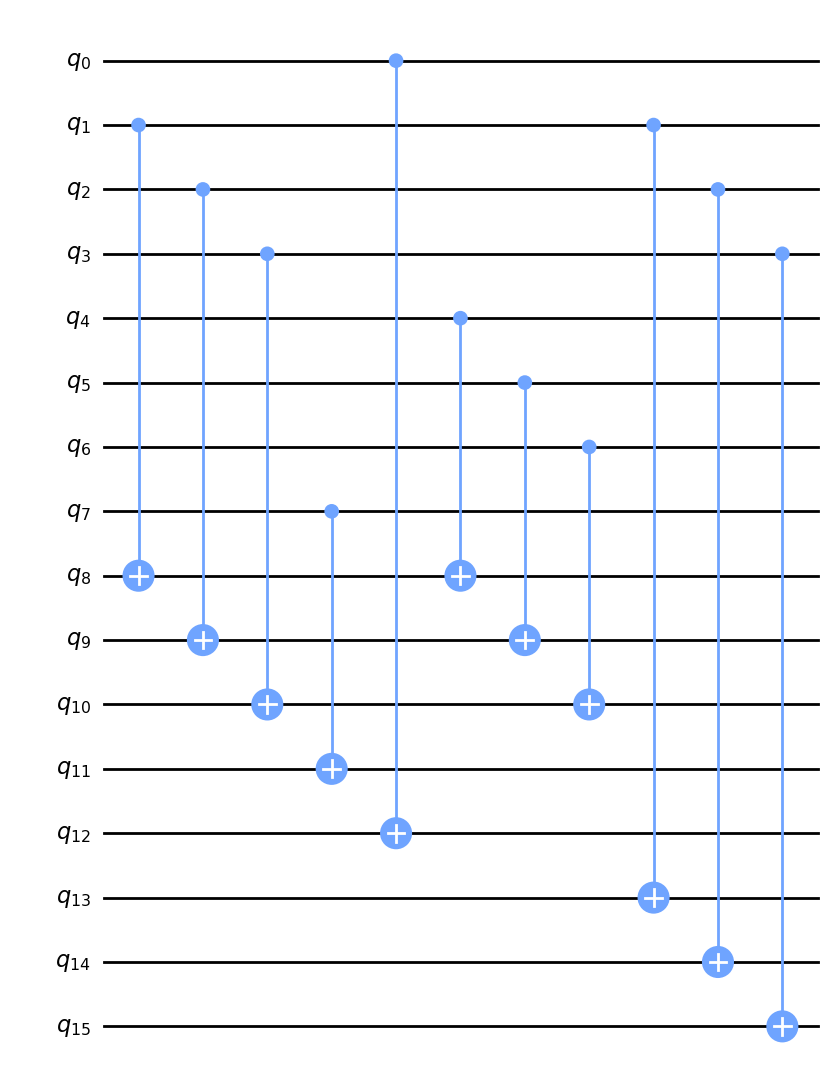

In [3]:
hash_simp.export("qiskit").draw("mpl")


Now we use our quantum function as an oracle for a Grover search, in order to find which input maps to the value `0xca`.

In [4]:
from qlasskit.algorithms import Grover

q_algo = Grover(hash_simp, Qint8(0xCA))

Then we use our prefered framework and simulator for sampling the result; this is an example using `qiskit` with `aer_simulator`.

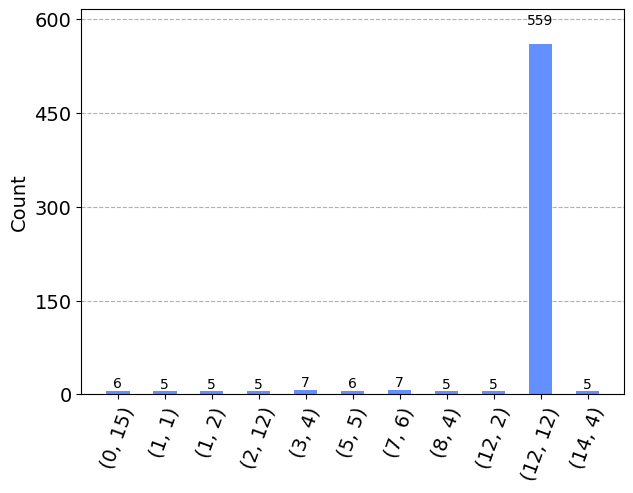

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

qc = q_algo.export("qiskit")
qc.measure_all()
simulator = AerSimulator()
circ = transpile(qc, simulator)
result = simulator.run(circ).result()
counts = result.get_counts(circ)

counts_readable = q_algo.decode_counts(counts, discard_lower=5)
plot_histogram(counts_readable)

Using `QlassF.original_f` we can double check the result without invoking a quantum simulator; calling it with the tuple `(12,12)` must result in the hash value `0xca`.

In [6]:
print(hex(hash_simp.original_f((12, 12))))

0xca
